In [39]:
import numpy as np
import matplotlib.pyplot as plt

$\textbf{Simulating Mock Point Source Catalogue}$

In [24]:
nsrcs =2000

RA = np.random.uniform(0.0,2.0*np.pi,nsrcs)
DEC = np.random.uniform(-np.pi/2.0,np.pi/2.0,nsrcs)

#flux density and spectral indexes

Smin=0.3
Smax=300
beta=-1.5

spectral_index_mean=-1
spectral_index_std=0.5
index = np.random.normal(spectral_index_mean,spectral_index_std,nsrcs)


flux_densities = ((Smax ** (beta + 1) - Smin ** (beta + 1)) * np.random.uniform(size=nsrcs) + Smin ** (
                beta + 1)) ** (1. / (beta + 1))

fluxes = np.array([[flux_densities[i],index[i]] for i in range(len(index))])

Text(0, 0.5, 'DEC[deg]')

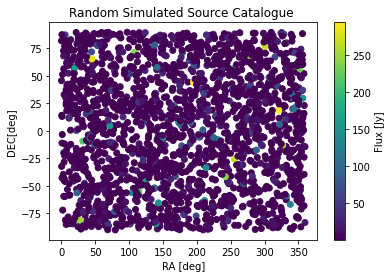

In [25]:
plt.title('Random Simulated Source Catalogue ')
plt.scatter(np.rad2deg(RA),np.rad2deg(DEC),c=flux_densities)
plt.colorbar(label ='Flux [Jy]')
plt.xlabel('RA [deg]')
plt.ylabel('DEC[deg]')
#plt.legend(loc='best')


$\textbf{Horizontal Coordinate}$


In [18]:

def pos_lmn(ra, dec, ra_0, dec_0):

    l = np.cos(dec)*np.sin(ra-ra_0)
    m = np.sin(dec)*np.cos(dec_0)-np.cos(dec)*np.sin(dec_0)*np.cos(ra-ra_0)
    n = np.sqrt(1-(l**2 + m**2))

    return np.array([l, m, n])


def get_srcs_above_horizon(time,RA, DEC, Flux):
    "This function return alt,az  and flux of the sources above the horizon"

    ra = RA*u.rad
    dec = DEC*u.rad
    skydata = SkyCoord(ra, dec, frame='icrs')


    # telescope location
    array_location = EarthLocation(lat=-30.72100*u.deg, lon=21.41100*u.deg, height=1460*u.m)
    
    #obseveration time
    
    obs_time = Time(time,format='jd')
    
    #convert ra/dec to Alt/az

    skydata_altaz = skydata.transform_to(AltAz(obstime=obs_time, location=array_location))
    
    #covert altaz to radians
    alt = np.deg2rad(np.array(skydata_altaz.alt))
    az = np.deg2rad(np.array(skydata_altaz.az))
    
    #selecting sources about the horizon
    ind_ahor = np.where(alt >= 0.0)
    alt_ahor = np.pi/2.0 - alt[ind_ahor]
    az_ahor = az[ind_ahor]
    flux_spec_ahor = Flux[ind_ahor]
    
    ra = ra[ind_ahor]
    dec = dec[ind_ahor]

    return [alt_ahor, az_ahor, ra.value, dec.value,flux_spec_ahor]


time = 2459247.75000

#phase center 

ra_0,dec_0 = 21.41100, -30.72100 #degrees


#get_srcs_above_horizon(time,RA, DEC, fluxes)


$\textbf{Observation Parameters}$

In [7]:
#Freq_array and lst
freq_array = np.linspace(100.0,200.0,100)
lsts = np.linspace(0.0,2.0*np.pi,100)

#array layout in ENU system (meters)
ant1 = np.array([0.0,0.0,0.0])
ant2 = np.array([16.0,0.0,0.0])
ant3 = np.array([32.0,0.0,0.0])
ant4 = np.array([250.0,0.0,0.0])

#Antenna dish parameters

diam = 14.0 # meters



$\textbf{Beam models}$


In [15]:
def gaussian_beam(theta, phi, sigma_fwhm, e_theta=0.0, e_phi=0.0, e_sigma=0.0):
    """
    This function compute the 2d gassian beam for full width half maximum,sigma_fwhm,
    value at location theta,phi (radians)
    """

    # Guassian Primary beam
    gpbeam = np.exp(-((theta - e_theta)**2 + (phi - e_phi)
                      ** 2)/(2.0*(sigma_fwhm + e_sigma)**2))

    return gpbeam


def sigma_func(d, freq_i):
    """
    This function compute the sigma_fwhm base on the Limits of Resolution: The Rayleigh Criterion

    """
    lambda_ = (3.0*10**8)/freq_i  # frequency in Hertz
    sigma = 0.44*(lambda_/d)
    return sigma


# parametized airydisk function

def param_airydisk(theta, phi, a_theta, a_phi, wavelen, theta_error=0.0, phi_error=0.0):

    if theta==0.0 and phi ==0.0:
        power_pattern =1.0
    else:

        k = (2.0*np.pi)/wavelen
        sqrt_term = np.sqrt((a_theta**2)*(theta - theta_error) **
                        2 + (a_phi**2)*(phi - phi_error)**2)

        power_pattern = np.power(2.0*sp.j1(k*sqrt_term)/(k*sqrt_term),2)

    return power_pattern



$\textbf{Sky Intensity}$

In [12]:
def flux_func(f, s_0, alpha): 
    return s_0*np.power(f/150, -alpha)


$\textbf{Simulating Visibility with Gaussian Beam}$

In [26]:

vis_14 = np.zeros((lsts.size, freq_array.size), dtype='complex')

for lst_i in range(lsts.size):

        ra = np.array([RA[src_i] for src_i in range(RA.size)])
        
        #Selecting Sources abouve the horizon
        alt_ahor, az_ahor, ra_ahor, dec_ahor, flux_spec_ahor = get_srcs_above_horizon(time,ra, DEC,fluxes)
        
        #convert ra/dec to lmn systems
        src_lmn = [pos_lmn(ra_ahor[i], dec_ahor[i], np.deg2rad(ra_0), np.deg2rad(dec_0)) for i in range(ra_ahor.size)]

        bl_xyz = ant2 - ant1

        vis_freq = np.zeros(freq_array.size, dtype='complex')

        for freq_i in range(len(freq_array)):

            wavelen = 3e8/(freq_array[freq_i]*1e6)
            sigma_fwhm = sigma_func(diam,freq_array[freq_i]*1e6)
            
            fringe = np.array([np.exp(-1j*2.0*np.pi*np.dot(bl_xyz/wavelen,src_lmn[src_i])) for src_i in range(len(src_lmn))])
            beam_ij = np.array([gaussian_beam(alt_ahor[src_i], az_ahor[src_i], sigma_fwhm)*gaussian_beam(alt_ahor[src_i], az_ahor[src_i],sigma_fwhm) for src_i in range(len(src_lmn))])
            
            Intensity = np.array([(1.0/src_lmn[src_i][2])*flux_func(freq_array[freq_i], flux_spec_ahor[src_i][0], flux_spec_ahor[src_i][1]) for src_i in range(len(src_lmn))])


            vis_freq[freq_i] = np.sum(Intensity*beam_ij*fringe)
        vis_14[lst_i, :] = vis_freq

In [28]:
vis_250 = np.zeros((lsts.size, freq_array.size), dtype='complex')

for lst_i in range(lsts.size):

        ra = np.array([RA[src_i] for src_i in range(RA.size)])
        
        #Selecting Sources abouve the horizon
        alt_ahor, az_ahor, ra_ahor, dec_ahor, flux_spec_ahor = get_srcs_above_horizon(time,ra, DEC,fluxes)
        
        #convert ra/dec to lmn systems
        src_lmn = [pos_lmn(ra_ahor[i], dec_ahor[i], np.deg2rad(ra_0), np.deg2rad(dec_0)) for i in range(ra_ahor.size)]

        bl_xyz = ant4 - ant1

        vis_freq = np.zeros(freq_array.size, dtype='complex')

        for freq_i in range(len(freq_array)):

            wavelen = 3e8/(freq_array[freq_i]*1e6)
            sigma_fwhm = sigma_func(diam,freq_array[freq_i]*1e6)
            
            fringe = np.array([np.exp(-1j*2.0*np.pi*np.dot(bl_xyz/wavelen,src_lmn[src_i])) for src_i in range(len(src_lmn))])
            beam_ij = np.array([gaussian_beam(alt_ahor[src_i], az_ahor[src_i], sigma_fwhm)*gaussian_beam(alt_ahor[src_i], az_ahor[src_i],sigma_fwhm) for src_i in range(len(src_lmn))])
            
            Intensity = np.array([(1.0/src_lmn[src_i][2])*flux_func(freq_array[freq_i], flux_spec_ahor[src_i][0], flux_spec_ahor[src_i][1]) for src_i in range(len(src_lmn))])


            vis_freq[freq_i] = np.sum(Intensity*beam_ij*fringe)
        vis_250[lst_i, :] = vis_freq

$\textbf{Visibility Amplitude & Phase}$

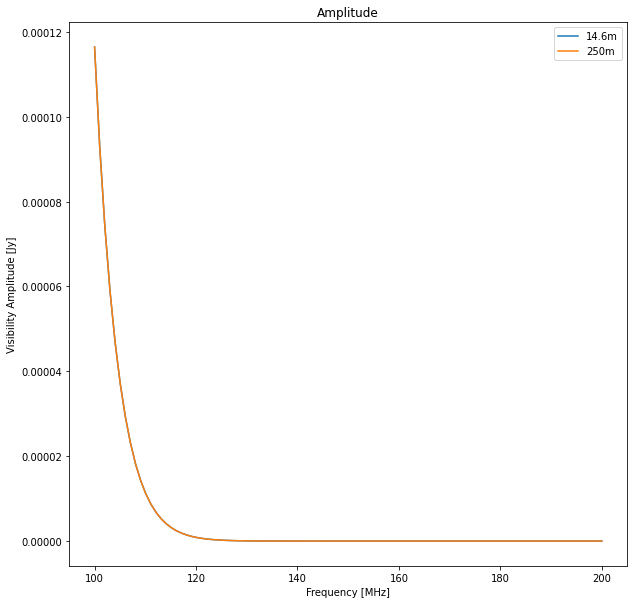

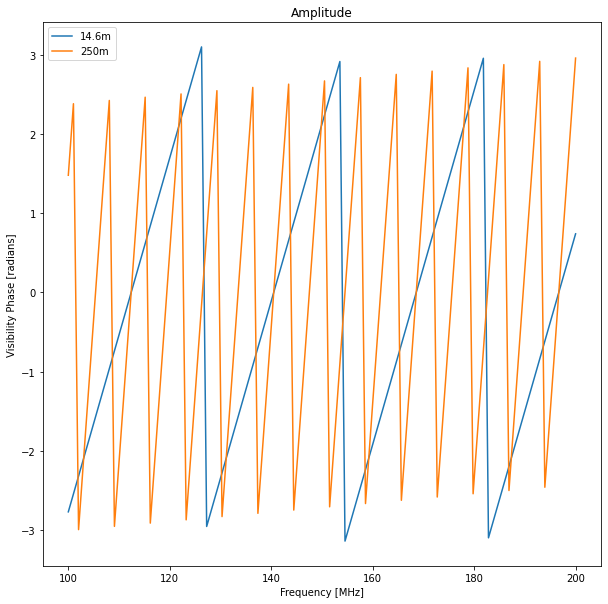

In [33]:
plt.figure(figsize=(10,10))
plt.title('Amplitude')
plt.plot(freq_array,np.abs(vis[0]),label='14.6m')
plt.plot(freq_array,np.abs(vis_250[0]),label='250m')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Visibility Amplitude [Jy]')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(10,10))
plt.title('Amplitude')
plt.plot(freq_array,np.angle(vis[0]),label='14.6m')
plt.plot(freq_array,np.angle(vis_250[0]),label='250m')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Visibility Phase [radians]')
plt.legend(loc='best')
plt.show()

$\textbf{Visibility Waterfalls}$

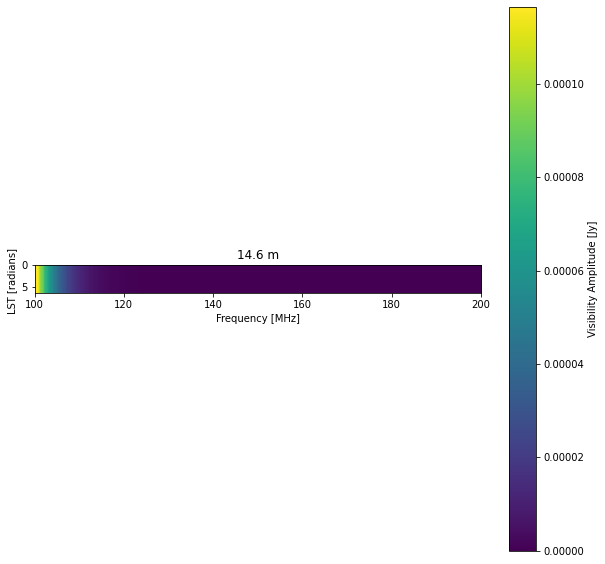

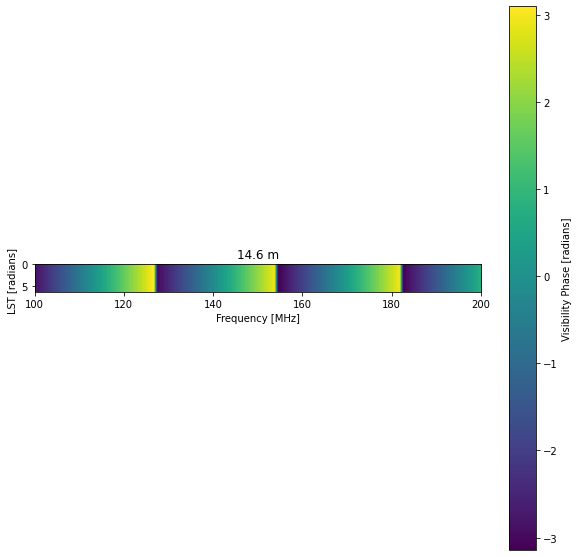

In [30]:
extent =[freq_array[0],freq_array[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("14.6 m")
plt.imshow(np.abs(vis),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Visibility Amplitude [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("14.6 m")
plt.imshow(np.angle(vis),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Visibility Phase [radians]')
plt.show()


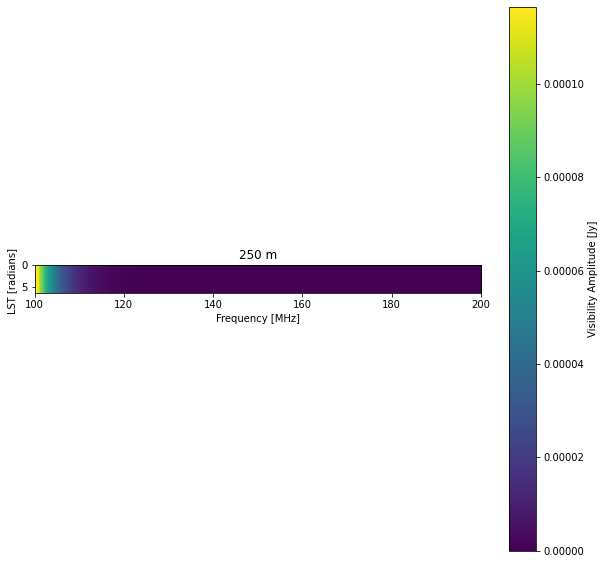

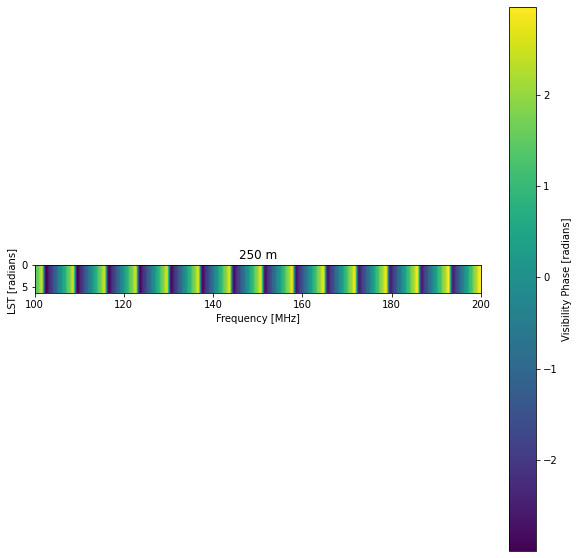

In [31]:
extent =[freq_array[0],freq_array[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("250 m")
plt.imshow(np.abs(vis_250),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Visibility Amplitude [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("250 m")
plt.imshow(np.angle(vis_250),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Visibility Phase [radians]')
plt.show()

$\textbf{Simulating Visibility with Airy Beam}$

In [34]:

vis_14_airy = np.zeros((lsts.size, freq_array.size), dtype='complex')

for lst_i in range(lsts.size):

        ra = np.array([RA[src_i] for src_i in range(RA.size)])
        
        #Selecting Sources abouve the horizon
        alt_ahor, az_ahor, ra_ahor, dec_ahor, flux_spec_ahor = get_srcs_above_horizon(time,ra, DEC,fluxes)
        
        #convert ra/dec to lmn systems
        src_lmn = [pos_lmn(ra_ahor[i], dec_ahor[i], np.deg2rad(ra_0), np.deg2rad(dec_0)) for i in range(ra_ahor.size)]

        bl_xyz = ant2 - ant1

        vis_freq = np.zeros(freq_array.size, dtype='complex')

        for freq_i in range(len(freq_array)):

            wavelen = 3e8/(freq_array[freq_i]*1e6)
            sigma_fwhm = sigma_func(diam,freq_array[freq_i]*1e6)
            
            fringe = np.array([np.exp(-1j*2.0*np.pi*np.dot(bl_xyz/wavelen,src_lmn[src_i])) for src_i in range(len(src_lmn))])
            beam_ij = np.array([param_airydisk(alt_ahor[src_i], az_ahor[src_i], diam/2.0, diam/2.0, wavelen)*param_airydisk(alt_ahor[src_i], az_ahor[src_i],diam/2.0,diam/2.0, wavelen) for src_i in range(len(src_lmn))])
            
            Intensity = np.array([(1.0/src_lmn[src_i][2])*flux_func(freq_array[freq_i], flux_spec_ahor[src_i][0], flux_spec_ahor[src_i][1]) for src_i in range(len(src_lmn))])


            vis_freq[freq_i] = np.sum(Intensity*beam_ij*fringe)
        vis_14_airy[lst_i, :] = vis_freq

In [35]:
vis_250_airy = np.zeros((lsts.size, freq_array.size), dtype='complex')

for lst_i in range(lsts.size):

        ra = np.array([RA[src_i] for src_i in range(RA.size)])
        
        #Selecting Sources abouve the horizon
        alt_ahor, az_ahor, ra_ahor, dec_ahor, flux_spec_ahor = get_srcs_above_horizon(time,ra, DEC,fluxes)
        
        #convert ra/dec to lmn systems
        src_lmn = [pos_lmn(ra_ahor[i], dec_ahor[i], np.deg2rad(ra_0), np.deg2rad(dec_0)) for i in range(ra_ahor.size)]

        bl_xyz = ant4 - ant1

        vis_freq = np.zeros(freq_array.size, dtype='complex')

        for freq_i in range(len(freq_array)):

            wavelen = 3e8/(freq_array[freq_i]*1e6)
            sigma_fwhm = sigma_func(diam,freq_array[freq_i]*1e6)
            
            fringe = np.array([np.exp(-1j*2.0*np.pi*np.dot(bl_xyz/wavelen,src_lmn[src_i])) for src_i in range(len(src_lmn))])
            beam_ij = np.array([param_airydisk(alt_ahor[src_i], az_ahor[src_i], diam/2.0, diam/2.0, wavelen)*param_airydisk(alt_ahor[src_i], az_ahor[src_i],diam/2.0,diam/2.0, wavelen) for src_i in range(len(src_lmn))])
            
            Intensity = np.array([(1.0/src_lmn[src_i][2])*flux_func(freq_array[freq_i], flux_spec_ahor[src_i][0], flux_spec_ahor[src_i][1]) for src_i in range(len(src_lmn))])


            vis_freq[freq_i] = np.sum(Intensity*beam_ij*fringe)
        vis_250_airy[lst_i, :] = vis_freq

$\textbf{Visibility Amplitude & Phase}$

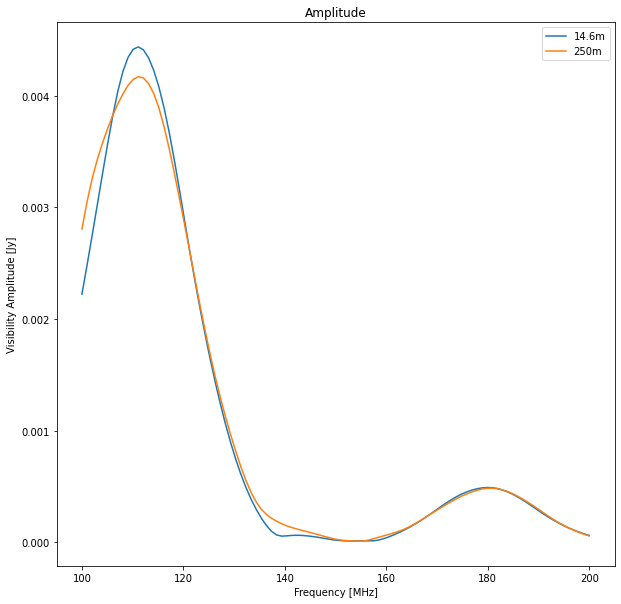

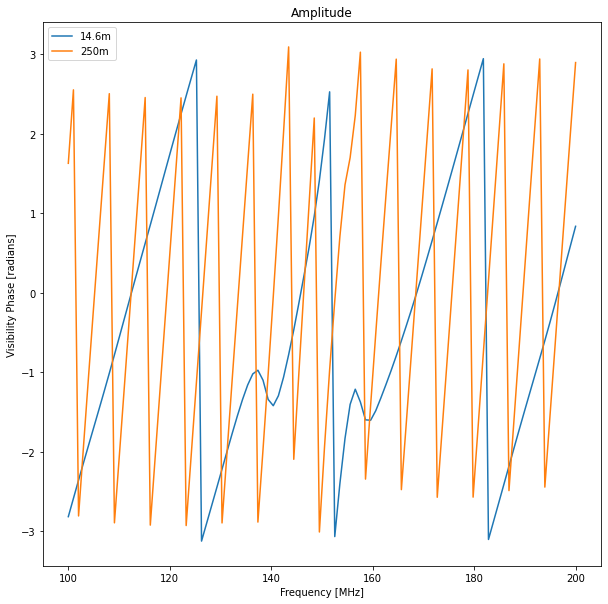

In [36]:
plt.figure(figsize=(10,10))
plt.title('Amplitude')
plt.plot(freq_array,np.abs(vis_14_airy[0]),label='14.6m')
plt.plot(freq_array,np.abs(vis_250_airy[0]),label='250m')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Visibility Amplitude [Jy]')
plt.legend(loc='best')
plt.show()


plt.figure(figsize=(10,10))
plt.title('Amplitude')
plt.plot(freq_array,np.angle(vis_14_airy[0]),label='14.6m')
plt.plot(freq_array,np.angle(vis_250_airy[0]),label='250m')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Visibility Phase [radians]')
plt.legend(loc='best')
plt.show()

$\textbf{Visibility Waterfalls}$

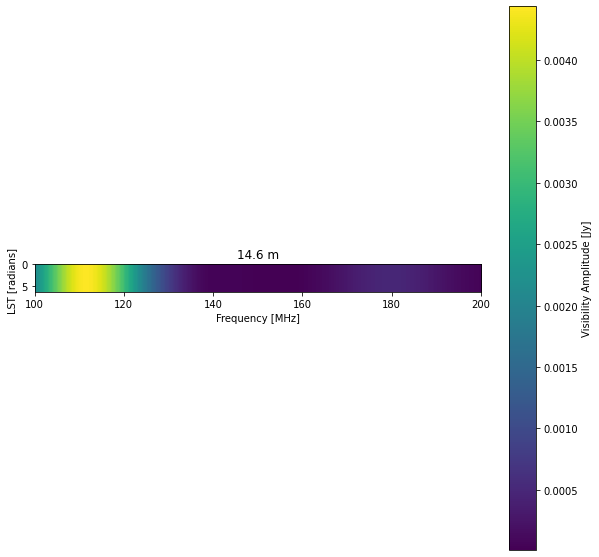

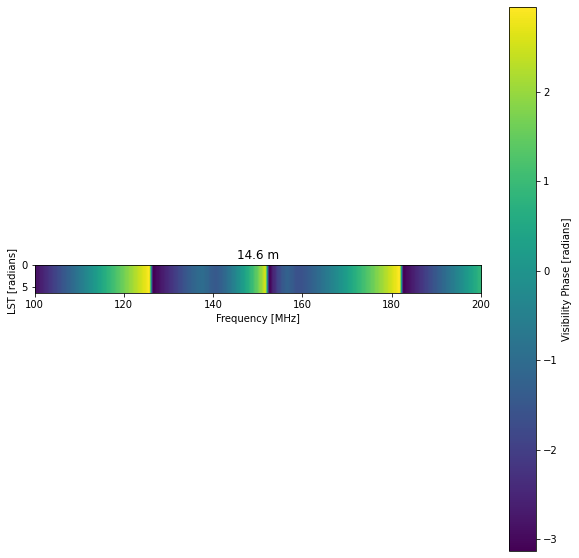

In [37]:
extent =[freq_array[0],freq_array[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("14.6 m")
plt.imshow(np.abs(vis_14_airy),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Visibility Amplitude [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("14.6 m")
plt.imshow(np.angle(vis_14_airy),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Visibility Phase [radians]')
plt.show()


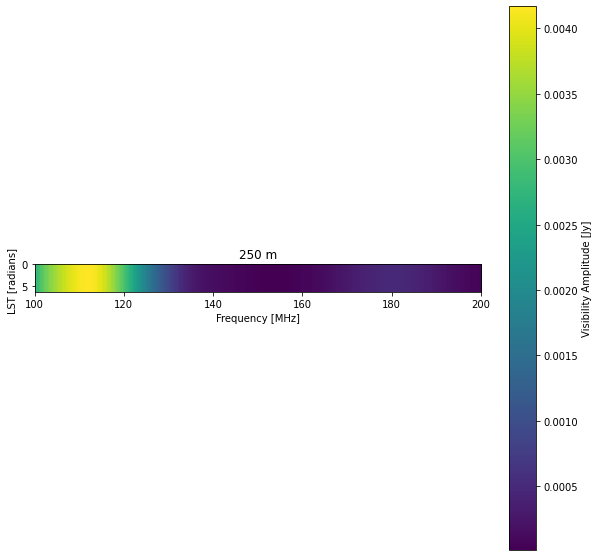

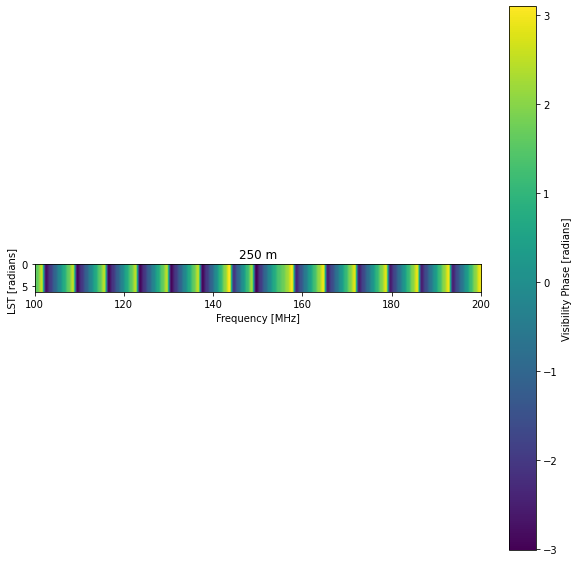

In [38]:
extent =[freq_array[0],freq_array[-1],lsts[-1],lsts[0]]

plt.figure(figsize =(10,10))
plt.title("250 m")
plt.imshow(np.abs(vis_250_airy),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Visibility Amplitude [Jy]')
plt.show()

plt.figure(figsize =(10,10))
plt.title("250 m")
plt.imshow(np.angle(vis_250_airy),extent=extent)
plt.xlabel('Frequency [MHz]')
plt.ylabel('LST [radians] ')
plt.colorbar(label= r'Visibility Phase [radians]')
plt.show()